## SunODE
https://sunode.readthedocs.io/en/latest/without_pymc.html

In [1]:
%matplotlib inline
import sunode
import numpy as np
import matplotlib.pyplot as plt
print("sunode", sunode.__version__)

sunode 0.4.0


## ODE model

In [2]:
params = {
    'α': (),
    'β': (),
    'γ': (),
    'δ': (),
}

states = {
    'hares': (),
    'lynxes': (),
}

In [3]:
def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.α * y.hares - p.β * y.lynxes * y.hares,
        'lynxes': p.δ * y.hares * y.lynxes - p.γ * y.lynxes,
    }

In [4]:
problem = sunode.SympyProblem(
    params=params,
    states=states,
    rhs_sympy=lotka_volterra,
    derivative_params=[('α',), ('β',), ('γ',), ('δ',)]
)

In [5]:
# solver = sunode.solver.Solver(problem, sens_mode="simultaneous")
solver = sunode.solver.AdjointSolver(problem)

In [6]:
y0 = np.zeros((), dtype=problem.state_dtype)
y0['hares'] = 1
y0['lynxes'] = 0.1

# At which time points do we want to evalue the solution
t = np.linspace(0, 10)

In [7]:
α, β, γ, δ = 0.1, 0.2, 0.3, 0.4
θ = α, β, γ, δ
solver.set_params_dict({
    'α': α,
    'β': β,
    'γ': γ,
    'δ': δ,
})

In [8]:
#y, sens = solver.make_output_buffers(tvals)
y, grad, lam = solver.make_output_buffers(t)
# solver.solve(t0=0, tvals=t, y0=y0, y_out=y, sens0=np.zeros_like(sens[0]), sens_out=sens)
solver.solve_forward(t0=t[0], tvals=t, y0=y0, y_out=y)

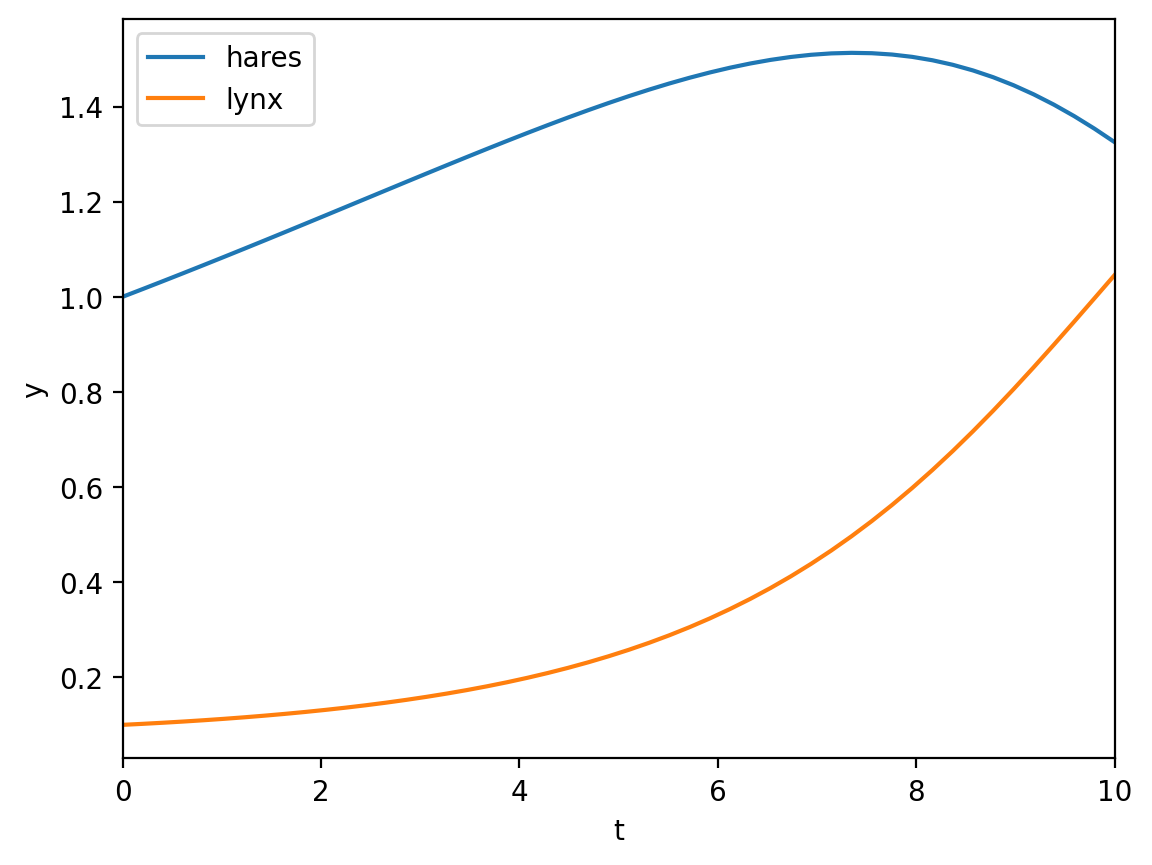

In [9]:
plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y')
plt.xlim(t[0], t[-1])
plt.legend(['hares', 'lynx']);

In [10]:
solver.solve_backward(t0=t[-1], tend=t[0], tvals=t, 
                      grads=np.ones((len(t), y.shape[-1])),
                      grad_out=grad, lamda_out=lam)

In [11]:
lam, grad

(array([-82.13485284,  25.18562792]),
 array([ 465.25049911, -103.50680243,  -25.88314792,   38.67576041]))

## Loss and gradient

In [15]:
def predict(θ):
    α, β, γ, δ = θ
    solver.set_params_dict({
        'α': α,
        'β': β,
        'γ': γ,
        'δ': δ,
    })
    y_out, grad, lam = solver.make_output_buffers(t)
    solver.solve_forward(t0=t[0], tvals=t, y0=y0, y_out=y_out)
    return y_out

θ_guess = 0.1, 0.1, 0.1, 0.1
yhat = predict(θ_guess)

In [16]:
def loss(y, θ): # mse
    yhat = predict(θ)
    resid = y - yhat
    return (resid * resid).sum()

loss(y, θ_guess)

14.487093439626495

In [17]:
def gradient(θ):
    α, β, γ, δ = θ
    solver.set_params_dict({
        'α': α,
        'β': β,
        'γ': γ,
        'δ': δ,
    })
    y_out, grad_out, lam_out = solver.make_output_buffers(t)
    solver.solve_forward(t0=t[0], tvals=t, y0=y0, y_out=y_out)
    res = (y - y_out)
    solver.solve_backward(t0=t[-1], tend=t[0], tvals=t, 
                      grads=-2*res,
                      grad_out=grad_out, lamda_out=lam_out)
    return grad_out

θ_guess = 0.1, 0.1, 0.1, 0.1
grad = gradient(θ_guess)
grad

array([433.82952474, -50.6250329 ,  52.96938998, -75.86014686])

## Gradient checking

In [18]:
α, β, γ, δ = θ_guess
Δ = 1e-6

In [20]:
# yhat1 = predict((α+Δα/2, β, γ, δ))
# yhat2 = predict((α-Δα/2, β, γ, δ))
# (yhat1.sum() - yhat2.sum())/Δα, grad[0]

L1 = loss(y, (α+Δ/2, β, γ, δ))
L2 = loss(y, (α-Δ/2, β, γ, δ))
(L1-L2)/Δ, grad[0]

(433.82952247483786, 433.8295247366786)

In [21]:
# yhat1 = predict((α, β+Δβ/2, γ, δ))
# yhat2 = predict((α, β-Δβ/2, γ, δ))
# (yhat1.sum() - yhat2.sum())/Δβ, grad[1]

L1 = loss(y, (α, β+Δ/2, γ, δ))
L2 = loss(y, (α, β-Δ/2, γ, δ))
(L1-L2)/Δ, grad[1]

(-50.62503427133436, -50.62503290111857)

In [22]:
L1 = loss(y, (α, β, γ+Δ/2, δ))
L2 = loss(y, (α, β, γ-Δ/2, δ))
(L1-L2)/Δ, grad[2]

(52.96939328225392, 52.969389983518944)

In [23]:
L1 = loss(y, (α, β, γ, δ+Δ/2))
L2 = loss(y, (α, β, γ, δ-Δ/2))
(L1-L2)/Δ, grad[3]

(-75.86015293803428, -75.860146862688)

## Gredienct descent

In [41]:
def average(p, c, β):
    return β * p + (1 - β) * c       
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, grad):
        if self.m is None:
            self.m = 0
        if self.v is None:
            self.v = 0

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, grad, self.β1)        
        self.v = average(self.v, (grad*grad), self.β2)

        updates = -αt * self.m / (np.sqrt(self.v) + self.ϵ)
        assert np.isfinite(updates).all()
        return updates

In [46]:
θ_hat = np.array([0.1, 0.1, 0.1, 0.1])
η = np.array([0.0001, 0.0001, 0.0001, 0.0001])
imax = 10000
opt = AdamOptimizer()

In [47]:
print("L = {:.2g}, θ = (({:.4f}, {:.4f}, {:.4f}, {:.4f}))".format(loss(y, θ), *θ))
for i in range(imax):
    grad = gradient(θ_hat)
    Δθ = opt.send(grad)
    θ_hat += Δθ
    if i % (imax // 50) == 0:
        print("L = {:.2g}, θ_hat = ({:.4f}, {:.4f}, {:.4f}, {:.4f}) ".format(loss(y, θ_hat), *θ_hat))

L = 0, θ = ((0.1000, 0.2000, 0.3000, 0.4000))
L = 14, θ_hat = (0.0990, 0.1010, 0.0990, 0.1010) 
L = 0.097, θ_hat = (0.0857, 0.1328, 0.0120, 0.1865) 
L = 0.054, θ_hat = (0.0925, 0.1573, 0.0141, 0.1865) 
L = 0.034, θ_hat = (0.0977, 0.1765, 0.0164, 0.1869) 
L = 0.028, θ_hat = (0.1008, 0.1884, 0.0187, 0.1878) 
L = 0.026, θ_hat = (0.1024, 0.1943, 0.0211, 0.1891) 
L = 0.026, θ_hat = (0.1030, 0.1967, 0.0237, 0.1909) 
L = 0.025, θ_hat = (0.1032, 0.1975, 0.0265, 0.1930) 
L = 0.025, θ_hat = (0.1032, 0.1978, 0.0297, 0.1953) 
L = 0.024, θ_hat = (0.1032, 0.1978, 0.0332, 0.1980) 
L = 0.023, θ_hat = (0.1031, 0.1978, 0.0371, 0.2010) 
L = 0.022, θ_hat = (0.1030, 0.1978, 0.0415, 0.2042) 
L = 0.022, θ_hat = (0.1030, 0.1978, 0.0462, 0.2078) 
L = 0.021, θ_hat = (0.1029, 0.1978, 0.0514, 0.2118) 
L = 0.02, θ_hat = (0.1028, 0.1978, 0.0570, 0.2160) 
L = 0.019, θ_hat = (0.1027, 0.1978, 0.0632, 0.2207) 
L = 0.018, θ_hat = (0.1027, 0.1978, 0.0698, 0.2257) 
L = 0.017, θ_hat = (0.1026, 0.1978, 0.0769, 0.2310) 
L = 